## Importing packages

In [116]:
# Importing libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

## Camera calibration

In [117]:
import glob
nx, ny = 9, 6

objpoints =[] #3D points in real world
imgpoints = [] #2D points in image plane
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #coordinates generation

cal_names = glob.glob("camera_cal/calibration*.jpg")
for name in cal_names:
    img = mpimg.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #Convert to gray
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dst, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) 

## Testing calibration

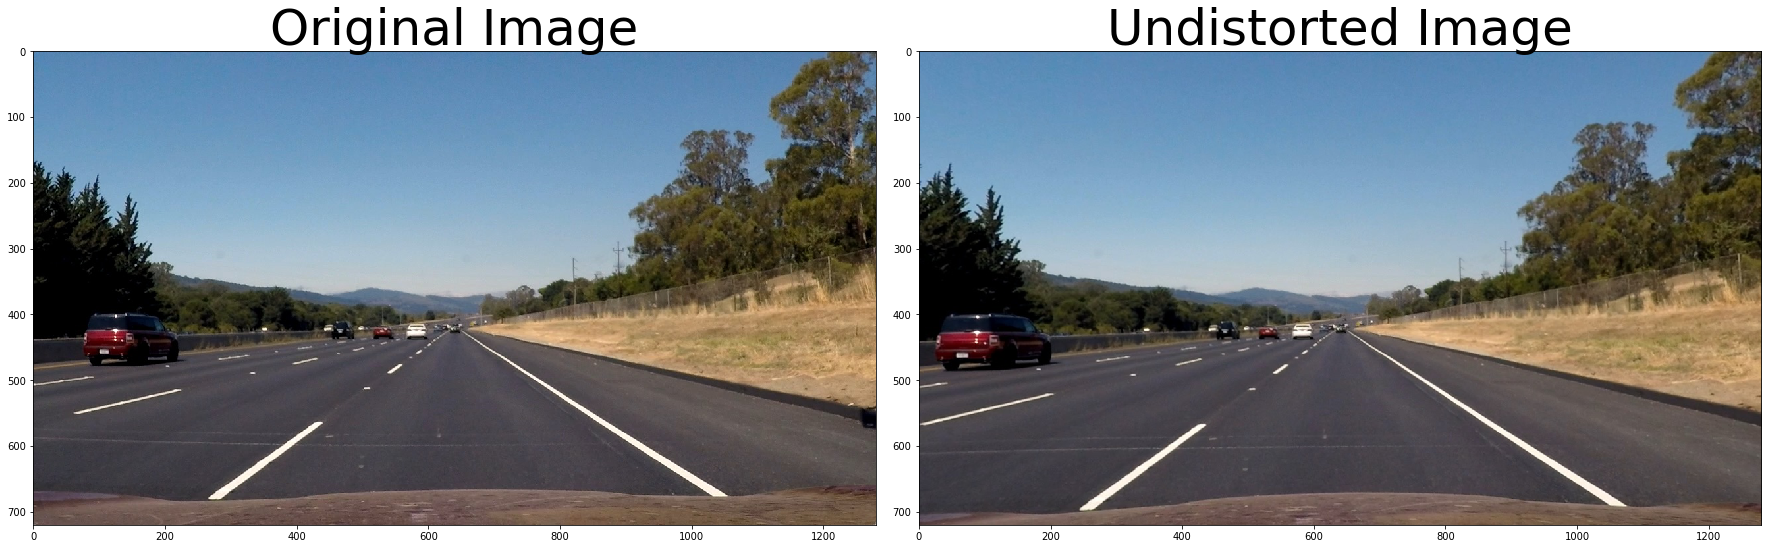

In [141]:
img_list = os.listdir("test_images/")
img = mpimg.imread('test_images/'+img_list[2])
undistorted = cv2.undistort(img, mtx, dst, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholding using gradients and color transforms

Sobel function is used to find different gradients and then a combined condition is used to find the output for the gradients. Then a threshold is applied on the saturation and lightness channel which is then pooled with the gradient output which leads to pretty satisfactory results.

In [119]:
def thresholding(image):
    dir_binary = dir_threshold(image, sobel_kernel=25, thresh=(0.7, 1.3))
    mag_binary = mag_thresh(image, sobel_kernel=25, mag_thresh=(50, 80))
    grad_y = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    grad_x = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
    gradients = np.zeros_like(dir_binary)
    gradients[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 #Multiple conditions for better results
    hls_binary = hls_select(image, s_thresh=(100, 255), l_thresh=(130, 255)) 
    out = np.zeros_like(dir_binary)
    out[(gradients==1)|(hls_binary==1)]=1
    return out

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_graddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(abs_graddir)
    binary_output[(abs_graddir >= thresh[0]) & (abs_graddir <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output
    
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray =cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8((255*abs_sobel)/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output
    
def hls_select(img, s_thresh=(0, 255), l_thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel>s_thresh[0])&(s_channel<=s_thresh[1])&(l_channel>=l_thresh[0])&(l_channel<=l_thresh[1])] = 1
    return binary_output

### Testing thresholding and ROI

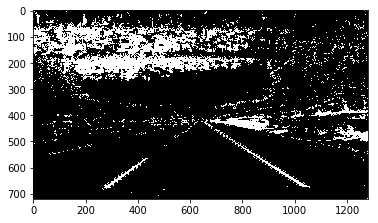

In [120]:
img_list = os.listdir("test_images/")
image = mpimg.imread('test_images/'+img_list[2])
ysize = image.shape[0]
xsize = image.shape[1]
output = thresholding(image)
plt.imshow(output, cmap='gray')

In [121]:
def roi_mask(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

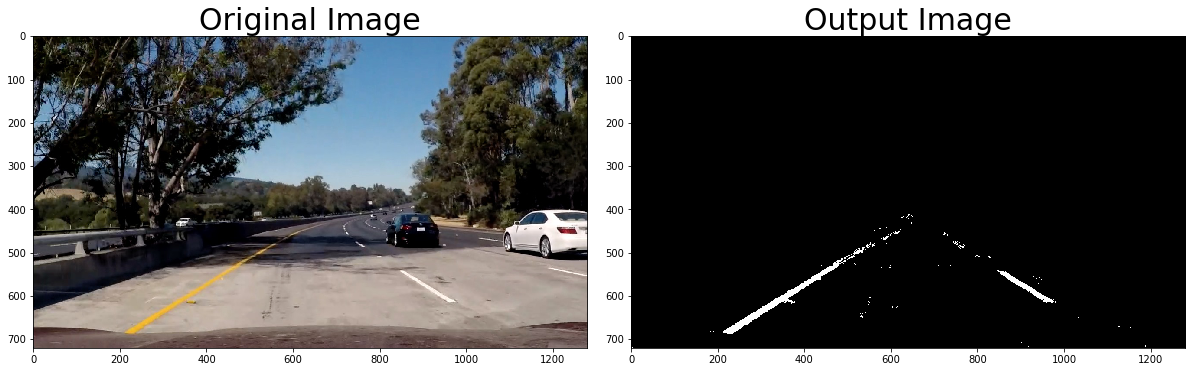

In [122]:
img_list = os.listdir("test_images/")
image = mpimg.imread('test_images/'+img_list[0])
height = image.shape[0]
width = image.shape[1]
offset = 50
vertices = np.array([[(0, height-1), (width//2, height//2+offset), (width-1, height-1)]], dtype=np.int32)
# vertices = np.array([[(0,height-1), (width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
thr = thresholding(image)
output = roi_mask(thr, vertices)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(output, cmap='gray')
ax2.set_title('Output Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

### Estimating the source points

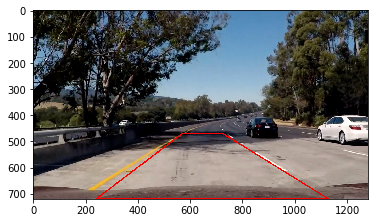

In [123]:
bottom_left = [240,image.shape[0]]
bottom_right = [1130, image.shape[0]]
top_left = [570, 470]
top_right = [725, 470]
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = image.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)
plt.imshow(copy)

In [124]:
def pers_transform(image):
    bottom_left = [240,image.shape[0]]
    bottom_right = [1130, image.shape[0]]
    top_left = [570, 470]
    top_right = [725, 470]
    height = image.shape[0]
    src = np.float32([bottom_left,bottom_right,top_right,top_left]) #defining the source points for the real image
    dest = np.float32([[300, height-20],[900, height-20],[900, 20],[300,20]]) #defining the destination points
    size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(image, M, size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

### Testing perspective transform

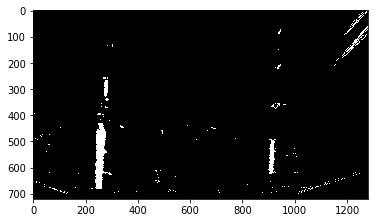

In [125]:
img_list = os.listdir("test_images/")
image = mpimg.imread('test_images/'+img_list[0])
test_pt, M, Minv = pers_transform(image)
test_pt = thresholding(test_pt)
plt.imshow(test_pt, cmap='gray')

## Sliding window search

In [126]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print (left_fit)
    print(right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty, lefty, righty

[  1.17608904e-04  -1.80332577e-01   3.20896539e+02]
[  1.94021811e-04  -1.87679300e-01   9.65099945e+02]


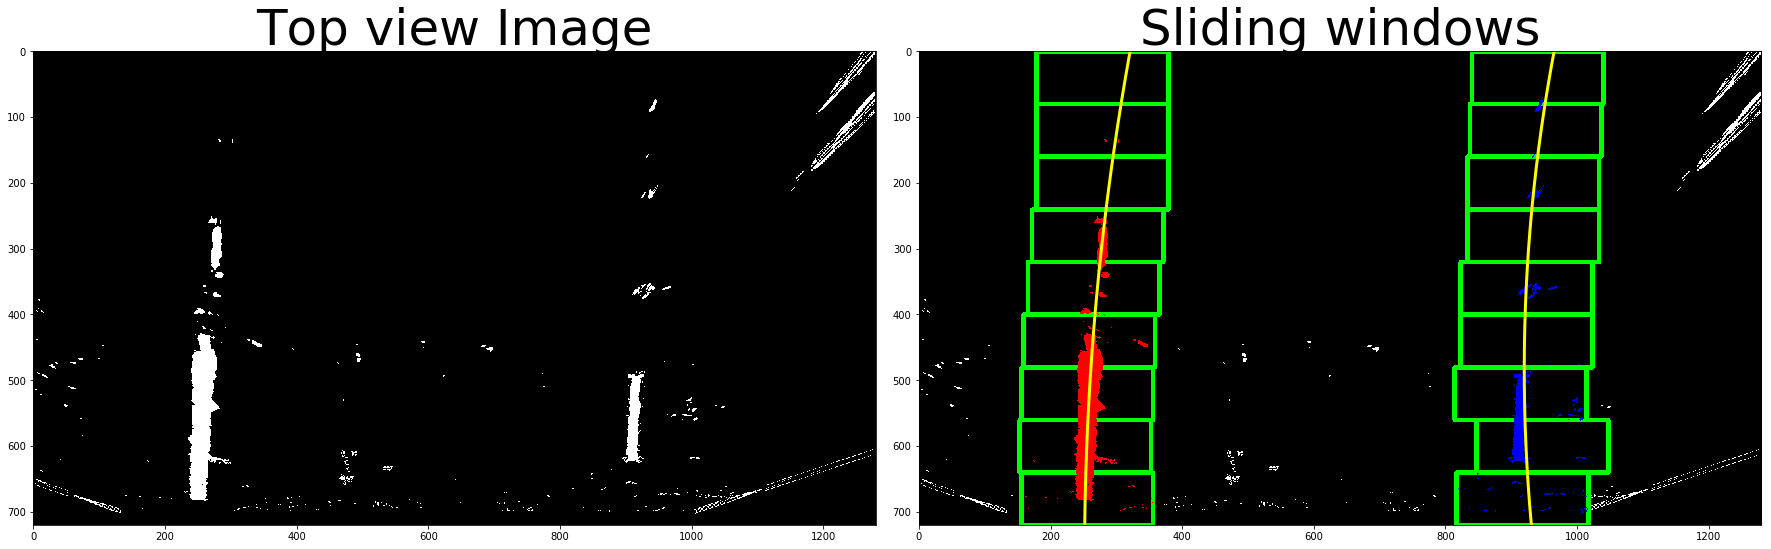

In [127]:
input_img = np.uint8(255*test_pt/abs(test_pt))
out_img, left_fitx, right_fitx, ploty, lefty, righty = fit_polynomial(input_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(input_img, cmap='gray')
ax1.set_title('Top view Image', fontsize=50)
ax2.imshow(out_img)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
ax2.set_title('Sliding windows', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Searching from prior

In [128]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    #Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Search withi the margins for activated pixels
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    return result

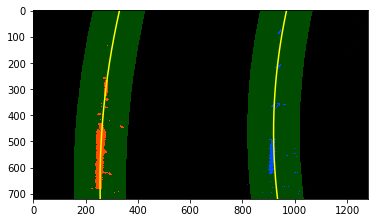

In [129]:
left_fit = np.array([6.11677438e-05, -1.93287943e-01, 3.97700135e+02])
right_fit = np.array([2.21255757e-04, -2.43666029e-01, 9.81832151e+02])
input_img = np.uint8(255*test_pt/abs(test_pt))
out_img = search_around_poly(input_img, left_fit, right_fit)
plt.imshow(out_img)

## Measuring radius of curvature

In [130]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, input_img.shape[0]-1, input_img.shape[0])
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_fitx)
right_curve_rad = measure_radius_of_curvature(right_fitx)
print(left_curve_rad, right_curve_rad)
lane_center = (left_fitx[input_img.shape[0]-1] + right_fitx[input_img.shape[0]-1])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
offset = abs(input_img.shape[1]/2 - lane_center)
offset_m = offset*xm_per_pix
print(lane_center)

1396.38428409 846.604770148
591.248435094


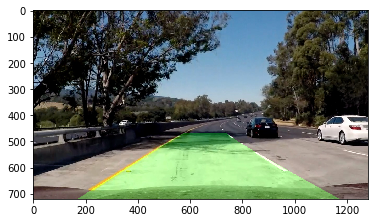

In [131]:
size = (image.shape[1], image.shape[0])
test_pt = np.uint8(255*test_pt/np.max(test_pt))
out_img = np.dstack((test_pt, test_pt, test_pt))*255
y_points = np.linspace(0, input_img.shape[0]-1, input_img.shape[0])
left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
unwarped = cv2.warpPerspective(out_img, Minv, size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
plt.imshow(result)

# Putting everything together!

In [132]:
from collections import deque
class Line:
    def __init__(self):
        # Was the line was found?
        self.found = False
        # X and Y values of the non-zero points
        self.X = None
        self.Y = None
        # Store the coefficients for averaging and last fitx values
        self.coefficients = deque(maxlen=10)
        # Radius of curvature
        self.roc = deque(maxlen=10)
        
    def scratch_search(self, img):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        midpoint = np.int(histogram.shape[0]//2)
        if self==Left:
            base = np.argmax(histogram[:midpoint])
        else:
            base = np.argmax(histogram[midpoint:]) + midpoint
        
        nwindows = 9 # HYPERPARAMETERS
        margin = 100
        minpix = 50
        window_height = np.int(img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        base_current = base
        lane_inds = []
        for window in range(nwindows):
            # Identify window boundaries in x and y
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            winx_low = base_current - margin
            winx_high = base_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= winx_low) &  (nonzerox < winx_high)).nonzero()[0]
            # Append these indices to the list
            lane_inds.append(good_inds)
            
            if len(good_inds) > minpix:
                base_current = np.int(np.mean(nonzerox[good_inds]))
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        xvals = nonzerox[lane_inds]
        yvals = nonzeroy[lane_inds] 
        if len(xvals)>minpix*2:
            self.found=True
        else:
            xvals = self.X
            yvals = self.Y
        return xvals, yvals, self.found
    def search_from_prior(self, img):
        mean_coeff = np.mean(self.coefficients, axis=0)
        margin = 100
        # Grab activated pixels
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        lane_inds = ((nonzerox > (mean_coeff[0]*(nonzeroy**2) + mean_coeff[1]*nonzeroy + 
                    mean_coeff[2] - margin)) & (nonzerox < (mean_coeff[0]*(nonzeroy**2) + 
                    mean_coeff[1]*nonzeroy + mean_coeff[2] + margin)))
        xvals = nonzerox[lane_inds]
        yvals = nonzeroy[lane_inds] 
        if len(xvals)<100:
            self.found=False
        return xvals, yvals, self.found
    def find_roc(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        return curverad

# Final pipeline

In [137]:
def process_frame(image):
    height, width = image.shape[0], image.shape[1]
    #STEP 1: Calibration
    undist = cv2.undistort(image, mtx, dst, None, mtx)
    #STEP 2: Perspective transform
    warped, M, Minv = pers_transform(undist)
    #STEP 3: Thresholding
    binary = thresholding(warped)
    #STEP 4: Search using prior values and if a sufficient result is not obtained search using sliding window
    if (Left.found==True):
        leftx, lefty, Left.found = Left.search_from_prior(binary)
    if (Right.found==True):
        rightx, righty, Right.found = Right.search_from_prior(binary)
    if (Left.found==False):
        leftx, lefty, Left.found = Left.scratch_search(binary)
    if (Right.found==False):
        rightx, righty, Right.found = Right.scratch_search(binary)
    #STEP 5: Fitting a polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.X = leftx
    Left.Y = lefty
    #STEP 6: Appending the coefficients to the list of last 10 coefficients and using the mean as the final setof coefficients
    Left.coefficients.append(left_fit)
    fit_mean = np.mean(Left.coefficients, axis=0)
    y_points = np.linspace(0, height-1, height)
    left_fitx = fit_mean[0]*y_points**2 + fit_mean[1]*y_points + fit_mean[2]
    Left.fitx = left_fitx
    
    # Repeating the same for right lane
    right_fit = np.polyfit(righty, rightx, 2)
    Right.X = rightx
    Right.Y = righty
    Right.coefficients.append(right_fit)
    fit_mean = np.mean(Right.coefficients, axis=0)
    right_fitx = fit_mean[0]*y_points**2 + fit_mean[1]*y_points + fit_mean[2]
    Right.fitx = right_fitx
    
    #STEP 7: Calculating the radius of curvature and taking an average over the last 10 iterations
    Left.roc.append(Left.find_roc(leftx, lefty))
    Right.roc.append(Right.find_roc(rightx, righty))
    
    lane_center = (left_fitx[height-1] + right_fitx[height-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset = (width/2) - lane_center
    offset_m = offset*xm_per_pix

    size = (width, height)
    binary = np.uint8(255*binary/np.max(binary))
    out_img = np.dstack((binary, binary, binary))*255
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, Minv, size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
    final_roc = (np.mean(Left.roc) + np.mean(Right.roc))/2
    cv2.putText(result, 'Offset: {:.2f}m'.format(offset_m), (50,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Radius of curvature: {:.2f}m'.format(final_roc), (50,140),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    return result
        

## Pipeline testing

In [138]:
img_list = os.listdir("test_images/")
for img_name in img_list:
    image = mpimg.imread('test_images/'+img_name)
    Left = Line()
    Right = Line()
    test = process_frame(image)
    cv2.imwrite('output_images/'+img_name, test)

# Testing on videos

In [139]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [08:54<00:00,  2.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 6min 27s, sys: 19.3 s, total: 6min 47s
Wall time: 8min 57s


In [140]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

# Project 2: Advanced lane finding - Writeup
---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Working
#### 1. Camera Calibration
---

Camera calibration is performed on the images of a chessboard of size 9x6. Multiple images of the board from different angles are provided. For all these images, we first try to find the corners and if found, these coordinates are appended to the list of image points. Then the object and image points are used to get the camera matrix and the distortion coefficients. These are then used to undistort the images. Examples are available in the notebook.

---
#### 2. Perspective transform
---

The source points are obtained manually by eye balling and then recheking by drawing the points on a test image. The destination points are then decided in such a way that the two lanes are parallel in the output image.

---
#### 3. Thresholding
---

Sobel function is used to find different gradients and then a combined condition is used to find the output for the gradients. Then a threshold is applied on the saturation and lightness channel which is then pooled with the gradient output which leads to pretty satisfactory results.

---
#### 4. Fitting a polynomial
---

After finding the thresholded frame in a video the polynomial coefficients to fit the lane line can be found out using two methods, namely, sliding window search or search from prior. If the lines were obtained in the previous frame then the search from prior method is used to detect the lines in the new frame. If satisfactory results are not obtained for this frame, then the brute search that is the sliding window search is performed. The points then obtained are used to fit a polynomial using the polyfit function.

---
#### 5. Radius of curvature
---

Once the pixels corresponding to the lanelines have been obtained, they are used in the polyfit function together with the conversion factor for conversion from pixel to meters and the radius of curvature is determined from a formula. The radius of curvature is averaged over the last 10 iterations to avoid jerks in the reading. Also, the offset is calculated as the difference between the center of the two lane lines at the bottom of the image and the image center.

---
#### 6. Drawing the lane line
---

The coordinates obtained on the bird's eye view image are then converted back to the real space using the inversion matrix after the lane is drawn from the polynomial coefficients obtained in the previous step.

---

## Shortcomings
---

* The algorithm sometimes fails when the lighting conditions are bad.
* Any cracks or sometimes changes in shade of the road cause the algorithm to malfunction

---

## Possible improvements
---

* Better thresholding methods can be used to obtain the lane lines in multiple scenarios.